# Basics

You will learn basic usage of iminuit and how to approach standard fitting problems with `iminuit`.

`iminuit` is a Python frontend to the `Minuit2` library in C++, an integrated software that combines a local minimizer (called MIGRAD) and two error calculators (called HESSE and MINOS). You provide it an analytical function, which accepts one or several parameters, and an initial guess of the parameter values. It will then find a local minimum of this function starting from the initial guess. In that regard, iminuit minimizer is like other local minimizers, like those in `scipy.optimize`.

In addition, iminuit has the ability to compute **uncertainty estimates** for model parameters. `iminuit` was designed to solve statistics problems, where uncertainty estimates are an essential part of the result. The two ways of computing uncertainty estimates, HESSE and MINOS, have different advantages and disadvantages.

`iminuit` is the successor of `pyminuit`. If you used `pyminuit` before, you will find iminuit very familiar. An important feature of `iminuit` (and `pyminuit`) is that it uses introspection to detect the parameter names of your function. This is very convenient, especially when you work interactively in a Jupyter notebook. It also provides special output routines for Jupyter notebooks to pretty print the fit results, as you will see below.

In [2]:
# basic setup of the notebook
from matplotlib import pyplot as plt
import numpy as np

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

iminuit version: 2.21.3


## Quick start

In this first section, we look at a simple case where line should be fitted to scattered $(x, y)$ data. A line has two parameters $(\alpha, \beta)$. We go through the full fit, showing all basic steps to get you started quickly. In the following sections we will revisit the steps in more detail.

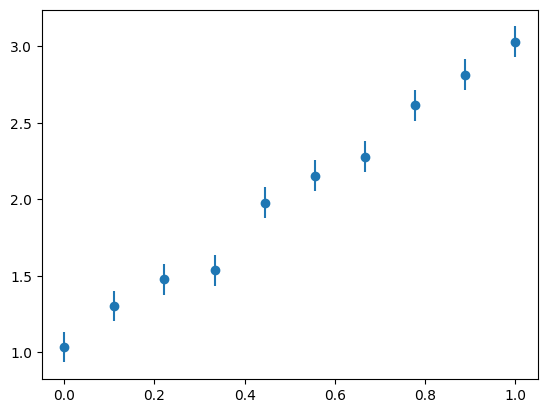

In [78]:
# our line model, unicode parameter names are supported :) 
def line(x, α, β):
    return α + x * β


# generate random toy data with random offsets in y
rng = np.random.default_rng(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1  # could also be an array
data_y = rng.normal(line(data_x, 1, 2), data_yerr)

# draw toy data
plt.errorbar(data_x, data_y, data_yerr, fmt="o");

To recover the parameters α and β of the line model from this data, we need to a minimise a suitable cost function. The cost function must be twice differentiable and have a minimum at the optimal parameters. We use the method of least-squares here, whose cost function computes the sum of squared residuals between the model and the data. The task of iminuit is to find the minimum of that function.

The iminuit module provides the `LeastSquares` class to conveniently generate a least-squares cost function.
We will revisit how to write one by hand in a later section. Using a built-in cost function comes with some perks, for example, the fit (if data are 1D) is automatically visualized in a Jupyter notebook.

In [4]:
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, α=0, β=0)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (χ²/ndof = 1.8)      │              Nfcn = 46               │
│ EDM = 1.13e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │            │            │         │         │       │
│ 1 │ β    │   1.97    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘

And that is all for a basic fit. The fit result is immediately visible here in the notebook, since calls to `m.migrad()` and `m.hesse()` return the `Minuit` object, which then automatically renders its state in a Jupyter notebook.

The automatically generated plot of the fitted function is intentionally very basic. You can make a nicer plot by hand with matplotlib.

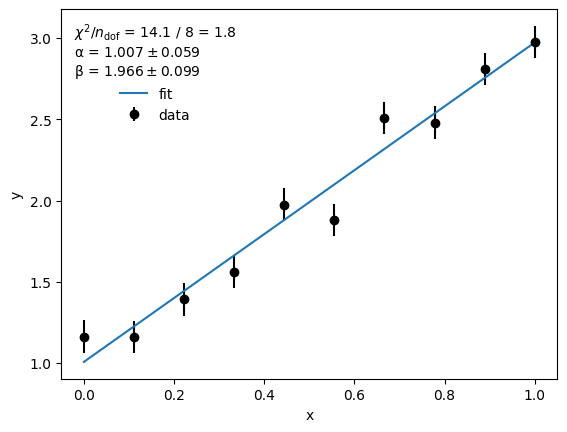

In [5]:
# draw data and fitted line
plt.errorbar(data_x, data_y, data_yerr, fmt="ok", label="data")
plt.plot(data_x, line(data_x, *m.values), label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",    
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info), frameon=False)
plt.xlabel("x")
plt.ylabel("y");

In the following, we dive into the details step by step; how the Minuit object is initialized, how to run the algorithms, and how to get the results.

iminuit was designed to make it easy to fit cost functions like `least_squares(...)`, where the parameters are individual arguments of the function. There is an alternative function signature that Minuit supports, which is more convenient when you explore models that have a not-yet-defined number of parameters, for example, a polynomial. Here, the parameters are passed as a numpy array. We will discuss both in the following, but focus on the first.

## Initialize the Minuit object

To minimize a function, one has to create an instance of the Minuit class and pass the function and a starting value for each parameter. This does not start the minimization yet, this will come later.

The `Minuit` object uses introspection to get the number and names of the function parameters automatically, so that they can be initialized with keywords.

In [6]:
m = Minuit(least_squares, α=0, β=0)

If we forget a parameter or mistype them, Minuit will raise an error. 

In [7]:
try:
    Minuit(least_squares)
except:
    import traceback
    traceback.print_exc()

Traceback (most recent call last):
  File "/var/folders/tl/pv6mt7z17tz0stm1fjfg01cc0000gn/T/ipykernel_19437/4202585354.py", line 2, in <module>
    Minuit(least_squares)
  File "/Users/hdembinski/Extern/iminuit/src/iminuit/minuit.py", line 626, in __init__
    raise RuntimeError(
RuntimeError: starting value(s) are required for α β


In [8]:
try:
    Minuit(least_squares, a=0, b=0)
except:
    import traceback
    traceback.print_exc()

Traceback (most recent call last):
  File "/var/folders/tl/pv6mt7z17tz0stm1fjfg01cc0000gn/T/ipykernel_19437/500655119.py", line 2, in <module>
    Minuit(least_squares, a=0, b=0)
  File "/Users/hdembinski/Extern/iminuit/src/iminuit/minuit.py", line 646, in __init__
    self._init_state = _make_init_state(self._pos2var, start, kwds)
  File "/Users/hdembinski/Extern/iminuit/src/iminuit/minuit.py", line 2637, in _make_init_state
    raise RuntimeError(
RuntimeError: a is not one of the parameters [α β]


### Initial parameter values

Minuit's main algorithm Migrad is a local minimizer. It searches for a local minimum by a doing a mix of Newton steps and gradient-descents from a starting point. If your function has several minima, the minimum found will depend on the starting point. Even if it has only one minimum, iminuit will converge to it faster if you start in the proximity of the minimum.

You can set the starting point using the parameter names as keywords, `<name> = <value>`.

In [9]:
Minuit(least_squares, α=5, β=5)  # pass starting values for α and β

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,5.00,0.05,,,,,
1,β,5.00,0.05,,,,,


Alternatively, the starting values can also be passed as positional arguments.

In [10]:
Minuit(least_squares, 5, 5)  # another way of passing starting values for α and β

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,5.00,0.05,,,,,
1,β,5.00,0.05,,,,,


You can also use iminuit with functions that accept numpy arrays. This has pros and cons.

**Pros**

- Easy to change number of fitted parameters
- Sometimes simpler function body that's easier to read
- Technically this is more efficient, but this is hardly going to be noticeable

**Cons**

- iminuit cannot figure out names for each parameter

To demonstrate, use a version of the line model which accepts the parameters as a numpy array.

In [11]:
def line_np(x, par):
    return np.polyval(par, x)  # for len(par) == 2, this is a line

Calling `line_np` with more or less arguments is easy and will use a polynomial of the corresponding order to predict the behavior of the data.

The builtin cost functions support such a model. For it to be detected properly, you need to pass the starting values in form a single sequence of numbers. 

In [12]:
least_squares_np = LeastSquares(data_x, data_y, data_yerr, line_np)

Minuit(least_squares_np, (5, 5))  # pass starting values as a sequence

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,


Any sequence will work for initialization, you can also pass a list or a numpy array here. iminuit uses the length of the sequence to detect how many parameters the model has. By default, the parameters are named automatically `x0` to `xN`. One can override this with the keyword `name`, passing a sequence of parameter names.

In [13]:
Minuit(least_squares_np, (5, 5), name=("a", "b"))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.00,0.05,,,,,
1,b,5.00,0.05,,,,,


Since `least_squares_np` works for parameter arrays of any length, one can easily change the number of fitted parameters.

In [14]:
# fit a forth order polynomial
Minuit(least_squares_np, (5, 5, 5, 5))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,
2,x2,5.00,0.05,,,,,
3,x3,5.00,0.05,,,,,


It is often useful to try different orders of a polynomial model. If the order is too small, the polynomial will not follow the data. If it is too large, it will overfit the data and pick up random fluctuations and not the underlying trend. One can figure out the right order by experimenting or using an algorithm like cross-validation.

### Inspecting current parameters

You can check the current parameter values and settings with the method `Minuit.params` at any time. It returns a special list of `Param` objects which pretty-prints in Jupyter and in the terminal.

In [15]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,0.0,0.1,,,,,
1,β,0.0,0.1,,,,,



This produces a nice table with numbers rounded according to the rules of the *Particle Data Group*. The table will be updated once you run the actual minimization. To look at the initial conditions later, use `Minuit.init_params`. We will come back to the meaning of *Hesse Error* and *Minos Error* later.

`Minuit.params` returns a tuple-like container of `Param` objects, which are data objects with attributes that one can query. Use `repr()` to get a detailed representation of the data object.

In [16]:
for p in m.params:
    print(repr(p), "\n")

Param(number=0, name='α', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None) 

Param(number=1, name='β', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None) 



### Parameters with limits

iminuit allows you to set parameter limits. Often a parameter is limited mathematically or physically to a certain range. For example, if your function contains `sqrt(x)`, then $x$ must be non-negative, $x \ge 0$. You can set upper-, lower-, or two-sided limits for each parameter individually with the `limits` property.

- lower limit: use `Minuit.limits[<name>] = (<value>, None)` or `(<value>, float("infinity"))`
- upper limit: use `Minuit.limits[<name>] = (None, <value>)` or `(-float("infinity"), <value>)`
- two-sided limit: use `Minuit.limits[<name>] = (<min_value>, <max_value>)`
- remove limits: use `Minuit.limits[<name>] = None` or  `(-float("infinity"), float("infinity")`

You can also set limits for several parameters at once with a sequence. To impose the limits $α \ge 0$ and $0 \le β \le 10$ in our example, we use:

In [17]:
m.limits = [(0, None), (0, 10)]
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,0.0,0.1,,,0,,
1,β,0.0,0.1,,,0,10,


It is also possible for the cost function to declare limits on its parameters. For this you need the `Annotated` type, which is available in Python-3.9 or later, and from the package `typing-extensions` in Python-3.8. The restrictions should be imported from the external package `annotated-types`. The builtin cost functions propagate such annotations of model parameters. 

In [18]:
# Annotated and Gt are imported from iminuit.typing here for universal compatibility, 
# but users should in general import them from external packages `typing-extensions` and
# `annotated-types` to decouple models from the `iminuit` package
from iminuit.typing import Annotated, Gt

def line_with_positive_slope(x, slope: Annotated[float, Gt(0)], offset):
    return slope * x + offset

lsq = LeastSquares(data_x, data_y, data_yerr, line_with_positive_slope)

Minuit(lsq, 1, 0)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,slope,1.00,0.01,,,0,,
1,offset,0.0,0.1,,,,,


You can reset the limit automatically set by such an annotation by calling `minuit_instance.limit["slope"] = None` before fitting, if you wish.

### Fixing and releasing parameters

Sometimes you have a parameter which you want to set to a fixed value temporarily. Perhaps you have a guess for its value, and you want to see how the other parameters adapt when this parameter is fixed to that value.

Or you have a complex function with many parameters that do not all affect the function at the same scale. Then you can manually help the minimizer to find the minimum faster by first fixing the less important parameters to initial guesses and fit only the important parameters. Once the minimum is found under these conditions, you can release the fixed parameters and optimize all parameters together. Minuit remembers the last state of the minimization and starts from there. The minimization time roughly scales with the square of the number of parameters. Iterated minimization over subspaces of the parameters can reduce that time.

To fix an individual parameter, use `minuit_instance.fixed[<name>] = True`. In our example, we fix α:

In [19]:
m.fixed["α"] = True
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,0.0,0.1,,,0,,yes
1,β,0.0,0.1,,,0,10,


In [20]:
# migrad will not vary α, only β
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 307.8 (χ²/ndof = 34.2)     │              Nfcn = 41               │
│ EDM = 2.53e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │    0.0    │    0.1    │            │            │    0    │         │  yes  │
│ 1 │ β    │   3.40    │   0.05    │            │            │    0    │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │       0  0.0000 │
│ β │  0.0000 0.00284 │
└───┴─────────────────┘

Wow we release α and fix β and minimize again, you can also use the parameter index instead of its name.

In [21]:
m.fixed[0] = False
m.fixed[1] = True
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 222.8 (χ²/ndof = 24.8)     │              Nfcn = 77               │
│ EDM = 5.24e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   0.292   │   0.032   │            │            │    0    │         │       │
│ 1 │ β    │   3.40    │   0.05    │            │            │    0    │   10    │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────┐
│   │     α     β │
├───┼─────────────┤
│ α │ 0.001  0e-3 │
│ β │  0e-3     0 │
└───┴─────────────┘

We could iterate this and would slowly approach the minimum, but that's silly; instead we release both parameters and run again. The array-like views support broadcasting to enable this shortcut notation:

In [22]:
m.fixed = False
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (χ²/ndof = 1.8)      │              Nfcn = 127              │
│ EDM = 5.79e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │            │            │    0    │         │       │
│ 1 │ β    │   1.97    │   0.10    │            │            │    0    │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘

### Varying starting points for minimization

It is sometimes useful to change the values of some fixed parameters by hand and fit the others or to restart the fit from another starting point. For example, if the cost function has several minima, changing the starting value can be used to find the other minimum.


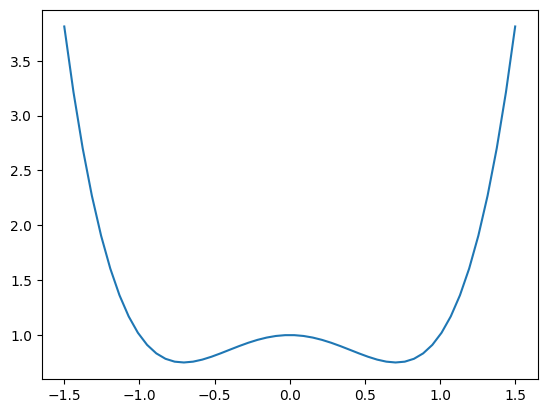

In [23]:
def cost_function_with_two_minima(x):
    return x ** 4 - x ** 2 + 1

x = np.linspace(-1.5, 1.5)
plt.plot(x, cost_function_with_two_minima(x));

In [24]:
# starting at -0.1 gives the left minimum
m = Minuit(cost_function_with_two_minima, x=-0.1)
m.migrad()
print("starting value -0.1, minimum at", m.values["x"])

# changing the starting value to 0.1 gives the right minimum
m.values["x"] = 0.1  # m.values[0] = 0.1 also works
m.migrad()
print("starting value +0.1, minimum at", m.values["x"])

starting value -0.1, minimum at -0.7085906080341975
starting value +0.1, minimum at 0.708796091342642


### Advanced: Simplex and Scan minimizers 

iminuit also offers two other minimizers which are less powerful than Migrad, but may be useful in special cases.

#### Simplex

The Nelder-Mead method (aka SIMPLEX) is well described on [Wikipedia](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method). It is a gradient-free minimization method that usually converges more slowly, but may be more robust. For some problems it can help to start the minimization with SIMPLEX and then finish with MIGRAD. Since the default stopping criterion for SIMPLEX is much more lax than MIGRAD, either running MIGRAD after SIMPLEX or reducing the tolerance with `Minuit.tol` is strongly recommended.

In [25]:
Minuit(cost_function_with_two_minima, x=10).simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.7501                     │              Nfcn = 23               │
│ EDM = 0.0176 (Goal: 0.1)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ NO Covariance │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    0.7    │    0.8    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Let's run MIGRAD after SIMPLEX to finish the minimization.

In [26]:
Minuit(cost_function_with_two_minima, x=10).simplex().migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.75                       │              Nfcn = 36               │
│ EDM = 1.12e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    0.7    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────┐
│   │   x │
├───┼─────┤
│ x │ 0.5 │
└───┴─────┘

This combination uses slightly fewer function evaluations and produced a more accurate result than just running MIGRAD alone in this case (for another problem this may not be true).

In [27]:
Minuit(cost_function_with_two_minima, x=10).migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.75                       │              Nfcn = 38               │
│ EDM = 4.38e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    0.7    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────┐
│   │     x │
├───┼───────┤
│ x │ 0.497 │
└───┴───────┘

#### Scan

Scan is a last resort. It does a N-dimensional grid scan over the parameter space. The number of function evaluations scale like $n^k$, where $k$ is the number of parameters and $n$ the number of steps along one dimension. Using scan for high-dimensional problems is unfeasible, but it can be useful in low-dimensional problems and when all but a few parameters are fixed. The scan needs bounds, which are best set with `Minuit.limits`. The number of scan points is set with the `ncall` keyword.

In [28]:
m = Minuit(cost_function_with_two_minima, x=10)
m.limits = (-10, 10)
m.scan(ncall=50)

┌─────────────────────────────────────────────────────────────────────────┐
│                                 Scan                                    │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.7657                     │              Nfcn = 55               │
│ EDM = 0.0188 (Goal: 0.1)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│ NO Covariance │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │   -0.6    │    0.9    │            │            │   -10   │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

The scan brought us in close proximity of the minimum.

In this case, the minimum is considered valid, because the EDM value is smaller than the EDM goal, but the scan may also end up in an invalid minimum, which is also ok. The scan minimizes the cost function using a finite number of steps, regardless of the EDM value (which is only computed after the scan for the minimum).

One should always run MIGRAD or SIMPLEX after a SCAN.

In [29]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.75                       │              Nfcn = 69               │
│ EDM = 1.92e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │   -0.7    │    0.7    │            │            │   -10   │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────┐
│   │     x │
├───┼───────┤
│ x │ 0.494 │
└───┴───────┘

### Advanced: Errordef

If you do not use one of the cost functions from the `iminuit.cost` module, you may need to pass an additional parameter to Minuit.

Minuit by default assumes that the function scales like a chi-square function when one of the parameters is moved away from the minimum. If your cost function is constructed as a log-likelihood, it scales differently and you must indicate that to Minuit wit the `errordef` parameter. Setting this is not needed for the cost functions in `iminuit.cost`.

The `errordef` parameter is required to compute correct uncertainties. If you don't care about uncertainty estimates (but why are you using Minuit then?), you can ignore it. Minuit supports two kinds of cost functions, the *negative log-likelihood* and the *least-squares* function. Each has a corresponding value for `errordef`:
 - `0.5` or the constant `Minuit.LIKELIHOOD` for negative log-likelihood functions 
 - `1` or the constant `Minuit.LEAST_SQUARES` for least-squares functions (the default)

If you like to understand the origin of these numbers, have a look into the study **Hesse and Minos**, which explains in depth how uncertainties are computed.

For our custom cost function, we could set `m.errordef=1` or `m.errordef=Minuit.LEAST_SQUARES`, which is more readable. An even better way is to add an attribute called `errordef` to the cost function. If such an attribute is present, Minuit uses it. Since this cost function has the default scaling, we do not need to set anything, but keep it in mind for negative log-likelihoods.

In [30]:
# a simple least-squares cost function looks like this...
def custom_least_squares(a, b):
    ym = line(data_x, a, b)
    z = (data_y - ym) / data_yerr
    return np.sum(z ** 2)

m = Minuit(custom_least_squares, 1, 2)
m.migrad()  # standard errordef, correct in this case

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06                      │              Nfcn = 32               │
│ EDM = 2.84e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.01    │   0.06    │            │            │         │         │       │
│ 1 │ b    │   1.97    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00345 -0.0049 │
│ b │ -0.0049 0.00982 │
└───┴─────────────────┘

In [31]:
m.errordef = Minuit.LIKELIHOOD  # errordef for negative log-likelihoods, wrong here
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06                      │              Nfcn = 42               │
│ EDM = 1.9e-22 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.01    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   1.97    │   0.07    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00173 -0.0025 │
│ b │ -0.0025 0.00491 │
└───┴─────────────────┘

The reported errors are now by a factor `sqrt(2)` smaller than they really are.

### Advanced: Initial step sizes

Minuit uses a gradient-descent method to find the minimum and the gradient is computed numerically using finite differences. The initial step size is used to compute the first gradient. A good step size is small compared to the curvature of the function, but large compared to numerical resolution. Using a good step size can slightly accelerate the convergence, but Minuit is not very sensitive to the choice. If you don't provide a value, iminuit will guess a step size based on a heuristic.

You can set initial step sizes with the `errors` property, `Minuit.errors[<name>] = <step size>`. Using an appropriate step size is important when you have you a parameter which has physical bounds. Varying the initial parameter value by the step size may not create a situation where the parameter goes outside of its bounds. For example, a parameter $x$ with $x > 0$ and initial value $0.1$ may not have a step size of $0.2$.

In our example, we could use an initial step size of $\Delta α = 0.1$ and $\Delta β = 0.2$. Setting both can be done conveniently by assigning a sequence:

In [32]:
m = Minuit(least_squares, α=5, β=5)
m.errors = (0.1, 0.2)  # assigning sequences works
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,5.0,0.1,,,,,
1,β,5.0,0.2,,,,,


Broadcasting is also supported.

In [33]:
m.errors = 0.3  # broadcasting
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,5.0,0.3,,,,,
1,β,5.0,0.3,,,,,


Only positive step sizes are allowed, non-positive values are replaced with the heuristic and a warning is emitted.

In [34]:
m.errors["β"] = -0.3
m.params

/Users/hdembinski/Extern/iminuit/src/iminuit/util.py:172: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,5.0,0.3,,,,,
1,β,5.000,0.003,,,,,


### Advanced: Override parameter name detection

iminuit tries hard to detect the parameter names correctly. It works for a large variety of cases. For example, if you pass a functor instead of a function, it will use the arguments of the `__call__` method, automatically skipping `self`. It even tries to parse the docstring if all else fails.

You can check which parameter names iminuit finds for your function with the `describe` function.

In [35]:
from iminuit import describe


def foo(x, y, z):
    pass


assert describe(foo) == ["x", "y", "z"]


class Foo:
    def __call__(self, a, b):
        pass


assert describe(Foo()) == ["a", "b"]

Sometimes parameter names cannot be determined, for example, when a function accepts a variable number of arguments.

In [36]:
def func_varargs(*args):  # function with variable number of arguments
    return np.sum((np.array(args) - 1) ** 2)

assert describe(func_varargs) == []

`describe` cannot detect the number and names of the parameters in this case and returns an empty list. If you work with functions that accept a variable number of arguments a lot, it is better to use a cost function which accepts a parameter array (this is explained in the next section).

When iminuit cannot detect the arguments, but you know how many arguments there are, or if you simply want to override the names found by iminuit, you can do that with the keyword `name`, like so:

In [37]:
Minuit(func_varargs, name=("a", "b"), a=1, b=2).migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.867e-19                  │              Nfcn = 24               │
│ EDM = 2.87e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │     1     │     1     │            │            │         │         │       │
│ 1 │ b    │     1     │     1     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────┐
│   │  a  b │
├───┼───────┤
│ a │  1 -0 │
│ b │ -0  1 │
└───┴───────┘

### Alternative interface: iminuit.minimize

Those familiar with scipy may find the `minimize` function useful. It exactly mimics the function interface of `scipy.optimize.minimize`, but uses `Minuit` for the actual minimization. The `scipy` package must be installed to use it.

In [38]:
from iminuit import minimize  # has same interface as scipy.optimize.minimize

minimize(least_squares_np, (5, 5))

  message: Optimization terminated successfully.
  success: True
      fun: 14.064905067721469
        x: [ 1.966e+00  1.007e+00]
 hess_inv: ┌────┬─────────────────┐
           │    │      x0      x1 │
           ├────┼─────────────────┤
           │ x0 │ 0.00491 -0.0025 │
           │ x1 │ -0.0025 0.00173 │
           └────┴─────────────────┘
     nfev: 32
     njev: 0
   minuit: ┌─────────────────────────────────────────────────────────────────────────┐
           │                                Migrad                                   │
           ├──────────────────────────────────┬──────────────────────────────────────┤
           │ FCN = 14.06                      │              Nfcn = 32               │
           │ EDM = 3.57e-23 (Goal: 0.0001)    │                                      │
           ├──────────────────────────────────┼──────────────────────────────────────┤
           │          Valid Minimum           │        No Parameters at limit        │
           ├──────

This interface is handy if you want to be able to switch between iminuit and `scipy.optimize.minimize` but we recommend the standard interface instead. It is an advantage of Minuit that you can interact and manually steer the minimization process. This is not as convenient with a functional interface like `minimize`.

## Investigating the fit status

Calling `Minuit.migrad()` runs the actual minimization with the Migrad algorithm. Migrad essentially tries a Newton-step and if that does not produce a smaller function value, it tries a line search along the direction of the gradient. So far so ordinary. The clever bits in Migrad are how various pathological cases are handled.

Let's look again at the output of `Minuit.migrad()`.

In [39]:
m = Minuit(least_squares, α=5, β=5)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (χ²/ndof = 1.8)      │              Nfcn = 30               │
│ EDM = 1.58e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │            │            │         │         │       │
│ 1 │ β    │   1.97    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘

The `Minuit.migrad` method returns the Minuit instance so that one can chain method calls. The instance also pretty prints the latest state of the minimization.

The first block in this output is showing information about the function minimum. This is good for a quick check:

- All blocks should be green.
- Purple means something bad. 
- Yellow may be bad or not. Be careful.

Let's see how it looks when the function is bad.

In [40]:
m_bad = Minuit(lambda x: 0, x=1)  # a constant function has no minimum
m_bad.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0                          │              Nfcn = 80               │
│ EDM = 0 (Goal: 0.0002)           │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │     1     │     0     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Coming back to our previous good example, the info about the function minimum can be directly accessed with `Minuit.fmin`:

In [41]:
m.fmin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (χ²/ndof = 1.8)      │              Nfcn = 30               │
│ EDM = 1.58e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [42]:
# print(repr(...)) to see a detailed representation of the data object
print(repr(m.fmin))

<FMin algorithm='Migrad' edm=1.5774541063068123e-21 edm_goal=0.0002 errordef=1.0 fval=14.064905067721467 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=30 ngrad=0 reduced_chi2=1.7581131334651834 time=0.0009364870000005965>


The most important one here is `is_valid`. If this is false, the fit did not converge and the result is useless. Since this is so often queried, a shortcut is provided with `Minuit.valid`.

If the fit fails, there is usually a numerical or logical issue.

- The fit function is not analytical everywhere in the parameter space or does not have a local minimum (the minimum may be at infinity, the extremum may be a saddle point or maximum). Indicators for this are `is_above_max_edm=True`, `hesse_failed=True`, `has_posdef_covar=False`, or `has_made_posdef_covar=True`. A non-analytical function is one with a discrete step, for example.
- Migrad reached the call limit before the convergence so that `has_reached_call_limit=True`. The used number of function calls is `nfcn`, and the call limit can be changed with the keyword argument `ncall` in the method  `Minuit.migrad`. Note that `nfcn` can be slightly larger than `ncall`, because Migrad internally only checks this condition after a full iteration, in which several function calls can happen.

Migrad detects convergence by a small `edm` value, the *estimated distance to minimum*. This is the difference between the current minimum value of the minimized function and the prediction based on the current local quadratic approximation of the function (something that Migrad computes as part of its algorithm). If the fit did not converge, `is_above_max_edm` is true.

If you are interested in parameter uncertainties, you should make sure that:

- `has_covariance`, `has_accurate_covar`, and `has_posdef_covar` are true.
- `has_made_posdef_covar` and `hesse_failed` are false.

The second object of interest after the fit is the parameter list, which can be directly accessed with `Minuit.params`.

In [43]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.06,,,,,
1,β,1.97,0.10,,,,,


In [44]:
for p in m.params:
    print(repr(p))

Param(number=0, name='α', value=1.007267694540621, error=0.05877538197171061, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None)
Param(number=1, name='β', value=1.9660364327564714, error=0.09908674010191873, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None)


`m.params` is a tuple-like container of `Param` data objects which contain information about the fitted parameters. Important fields are:
- `number`: parameter index.
- `name`: parameter name.
- `value`: value of the parameter at the minimum.
- `error`: uncertainty estimate for the parameter value.

Whether the uncertainty estimate is accurate depends on the correct mathematical modeling of your fitting problem and using the right `errordef` value for Minuit. What do we mean by correct mathematical modelling? If you look into the function `simple_least_squares(a, b)`, you see that each squared residuals is divided by the expected variance of the residual. This is necessary to get accurate uncertainty estimates for the parameters.

Sometimes the expected variance of the residual is not well known. If the function to minimize is a least-squares function, there is a simple test to check whether the residual variances are ok. One should look at the function value at the minimum, here given by `fmin.fval`, and divide it by the difference of the number of residuals and the number of fitted parameters, which can be conveniently queried with the attribute `nfit`. This is called reduced chi2.

In [45]:
m.fval / (len(data_y) - m.nfit)  # reduced chi2

1.7581131334651834

This value should be around 1. The more data points one has, the closer. If the value is much larger than 1, then the data variance is underestimated or the model does not describe the data. If the value is much smaller than 1, then the data variance is overestimated (perhaps because of positive correlations between the fluctuations of the data values).

The last block shows the covariance matrix, this is useful to check for large correlations which are usually a sign of trouble.

In [46]:
m.covariance

,α,β
α,0.00345,-0.0049 (-0.843)
β,-0.0049 (-0.843),0.00982


We will discuss this matrix in more detail in the next section.

##  Parameter uncertainties, covariances, and confidence intervals

You saw how to get the uncertainty of each individual parameter and how to access the full covariance matrix of all parameters together, which includes the correlations. Correlations are essential additional information if you want to work with parameter uncertainties seriously.

Minuit offers two ways to compute the parameter uncertainties, Hesse and Minos. Both have pros and cons.

### Hesse for covariance and correlation matrices

The Hesse algorithm numerically computes the matrix of second derivatives at the function minimum (called the Hesse matrix) and inverts it. The Hesse matrix is symmetric by construction. In the limit of infinite data samples to fit, the result of this computation converges to the true covariance matrix of the parameters. It often is already a good approximation even for finite statistic. These errors obtained from this method are sometimes called *parabolic errors*, because the Hesse matrix method is exact if the function is a hyperparabola (third and higher-order derivatives are all zero).

**Pros**

- (Comparably) fast computation.
- Provides covariance matrix for error propagation.

**Cons**

- May not have good coverage probability when sample size is small

The Migrad algorithm computes an approximation of the Hesse matrix automatically during minimization. When the default strategy is used, Minuit does a check whether this approximation is sufficiently accurate and if not, it computes the Hesse matrix automatically.

All this happens inside C++ Minuit and is a bit intransparent, so to be on the safe side, we recommend to call `Minuit.hesse` explicitly after the minimization, if exact errors are important.

In [47]:
# let's mess up the current errors a bit so that hesse has something to do
m.errors = (0.16, 0.2)
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.16,,,,,
1,β,1.97,0.20,,,,,


In [48]:
m.hesse().params # note the change in "Hesse Error"

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.06,,,,,
1,β,1.97,0.10,,,,,


#### Covariance and correlation Matrix

To see the covariance matrix of the parameters, you do:

In [49]:
m.covariance

,α,β
α,0.00345,-0.0049 (-0.843)
β,-0.0049 (-0.843),0.00982


The parameters α and β are strongly anti-correlated, the numerical value of the correlation is shown in parentheses. The correlation is also highlighted by the blue color of the off-diagonal elements.

In [50]:
print(repr(m.covariance))  # use print(repr(...) to skip pretty printing

[[ 0.00345455 -0.00490909]
 [-0.00490909  0.00981818]]


To get the correlation matrix, use:

In [51]:
m.covariance.correlation()  # returns a newly created correlation matrix

,α,β
α,1,-0.8
β,-0.8,1


Nonzero correlation is not necessarily a bad thing, but if you have freedom in redefining the parameters of the fit function, it is good to chose parameters which are not strongly correlated.

Minuit cannot accurately minimise the function if two parameters are (almost) perfectly (anti-)correlated. It also means that one of two parameters is superfluous, it doesn't add new information. You should rethink the fit function in this case and try to remove one of the parameters from the fit.

Both matrices are subclasses of numpy.ndarray, so you can use them everywhere you would use a numpy array. In addition, these matrices support value access via parameter names:

In [52]:
m.covariance["α", "β"]

-0.004909092060230799

### Minos for non-parabolic minima

Minuit has another algorithm to compute uncertainties: Minos. It implements the so-called profile likelihood method, where the neighborhood around the function minimum is scanned until the contour is found where the function increase by the value of `errordef`. The contour defines a confidence region that covers the true parameter point with a certain probability. The probability is exactly known in the limit of infinitely large data samples, but approximate for the finite case. Please consult a textbook about statistics about the mathematical details or look at the tutorial "Error computation with HESSE and MINOS".

**Pros**

- Produces pretty confidence regions in 2D (or higher) for scientific plots

**Cons**

- Computationally expensive
- Asymmetric errors are difficult to error-propagate

Minos is not automatically called during minimization, it needs to be called explicitly afterwards, like so:

In [53]:
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                               External                                  │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (χ²/ndof = 1.8)      │              Nfcn = 77               │
│ EDM = 2.75e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │   -0.06    │    0.06    │         │         │       │
│ 1 │ β    │   1.97    │   0.10    │   -0.10    │    0.10    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │           α           │           β           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.06   │   0.06    │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘

By now you are probably used to see green colors, which indicate that Minos ran successful. Be careful when these are red instead, Minos can fail. The fields in the new Minos table mean the following:
- Valid: Whether Minos considers the scan result valid.
- At Limit: True if Minos hit a parameter limit before the finishing the contour, which would be bad.
- Max FCN: True if Minos reached the maximum number of allowed calls before finishing the contour, also bad.
- New Min: True if Minos discovered a deeper local minimum in the neighborhood of the current one. Not necessarily bad, but should not happen.

The errors computed by Minos are now also shown in the parameter list.

In [54]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.06,-0.06,0.06,,,
1,β,1.97,0.10,-0.10,0.10,,,


If the absolute values of the Minos errors are very close to the Hesse Error, the function is well approximated by a hyperparabola around the minimum. You can use this as a check instead of explicitly plotting the function around the minimum (for which we provide tools, see below).

### Coverage probability of intervals constructed with Hesse and Minos algorithms

In applications, it is important to construct confidence regions with a well-known coverage probability. As previously mentioned, the coverage probability of the intervals constructed from the uncertainties reported by Hesse and Minos are not necessarily the standard 68 %.

Whether Hesse or Minos produce an interval with a coverage probability closer to the desired 68 % in finite samples depends on the case. There are theoretical results which suggest that Hesse may be slightly better, but we also found special cases where Minos intervals performed better.

Some sources claim that Minos gives better coverage when the cost function is not parabolic around the minimum; that is not generally true, in fact Hesse intervals may have better coverage.

As a rule-of-thumb, use Hesse as the default and try both algorithms if accurate coverage probability matters.

## Quick access to fit results

You get the main fit results with properties and methods from the `Minuit` object. We used several of them already. Here is a summary:

In [55]:
print(m.values)  # array-like view of the parameter values

<ValueView α=1.007267694540621 β=1.9660364327564714>


In [56]:
# access values by name or index
print("by name ", m.values["α"])
print("by index", m.values[0])

by name  1.007267694540621
by index 1.007267694540621


In [57]:
# iterate over values
for key, value in zip(m.parameters, m.values):
    print(f"{key} = {value}")

α = 1.007267694540621
β = 1.9660364327564714


In [58]:
# slicing works
print(m.values[:1])

[1.007267694540621]


In [59]:
print(m.errors)  # array-like view of symmetric uncertainties

<ErrorView α=0.058775386128484715 β=0.099086750179578>


`Minuit.errors` supports the same access as `Minuit.values`.

In [60]:
print(m.params) # parameter info (using str(m.params))

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │   -0.06    │    0.06    │         │         │       │
│ 1 │ β    │   1.97    │   0.10    │   -0.10    │    0.10    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [61]:
print(repr(m.params)) # parameter info (using repr(m.params))

(Param(number=0, name='α', value=1.007267694540621, error=0.058775386128484715, merror=(-0.058775381364227115, 0.058775381364824526), is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='β', value=1.9660364327564714, error=0.099086750179578, merror=(-0.09908673886090376, 0.09908673886184209), is_const=False, is_fixed=False, lower_limit=None, upper_limit=None))


In [62]:
# asymmetric uncertainties (using str(m.merrors))
print(m.merrors)

┌──────────┬───────────────────────┬───────────────────────┐
│          │           α           │           β           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.06   │   0.06    │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘


In [63]:
# asymmetric uncertainties (using repr(m.merrors))
print(repr(m.merrors))

<MErrors
  <MError number=0 name='α' lower=-0.058775381364227115 upper=0.058775381364824526 is_valid=True lower_valid=True upper_valid=True at_lower_limit=False at_upper_limit=False at_lower_max_fcn=False at_upper_max_fcn=False lower_new_min=False upper_new_min=False nfcn=12 min=1.007267694540621>,
  <MError number=1 name='β' lower=-0.09908673886090376 upper=0.09908673886184209 is_valid=True lower_valid=True upper_valid=True at_lower_limit=False at_upper_limit=False at_lower_max_fcn=False at_upper_max_fcn=False lower_new_min=False upper_new_min=False nfcn=12 min=1.9660364327564714>
>


In [64]:
print(m.covariance)  # covariance matrix computed by Hesse (using str(m.covariance))

┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘


In [65]:
print(repr(m.covariance))  # covariance matrix computed by Hesse (using repr(m.covariance))

[[ 0.00345455 -0.00490909]
 [-0.00490909  0.00981818]]


As already mentioned, you can play around with iminuit by assigning new values to `m.values` and `m.errors` and then run `m.migrad()` again. The values will be used as a starting point.

## Plotting

iminuit comes with built-in methods to draw the likelihood around the minimum. These can be used to draw confidence regions with a defined confidence level or for debugging the likelihood.

### Drawing confidence regions

To get a generic overview, use the method `Minuit.draw_mnmatrix`. It shows scans over the likelihood where all other parameters than the ones scanned are minimized, in other words, it is using the Minos algorithm. The regions and intervals found in this way correspond to uncertainty intervals. It is also a great way to see whether the likelihood is sane around the minimum.  

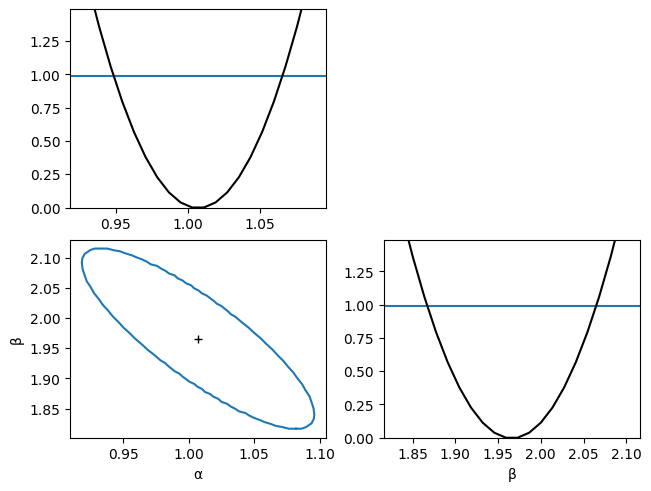

In [66]:
# find the minimum again after messing around with the parameters
m.migrad()

# draw matrix of likelihood contours for all pairs of parameters at 1, 2, 3 sigma
m.draw_mnmatrix();

The diagonal cells show the 1D profile around each parameter. The points were the horizontal lines cross the profile correspond to confidence intervals with confidence level `cl` (a probability). The off-diagonal cells show confidence regions with confidence level `cl`. Asymptotically (in large samples), the `cl` is equal to the probability that the region contains the true value. In finite samples, this is usually only approximately so.

For convenience, the drawing functions interpret `cl >= 1` as the number of standard deviations with a confidence level that corresponds to a standard normal distribution:

- cl = 1: 68.3 %
- cl = 2: 95.4 %
- cl = 3: 99.7 %

Drawing all profiles and regions can be time-consuming. The following commands show how to draw only individual contours or profiles.

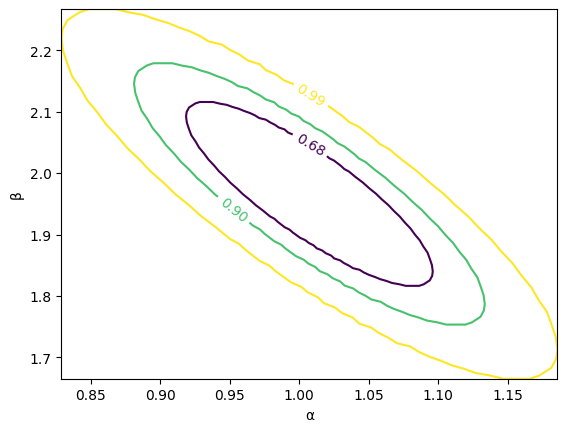

In [67]:
# draw three confidence regions with 68%, 90%, 99% confidence level
m.draw_mncontour("α", "β", cl=(0.68, 0.9, 0.99));

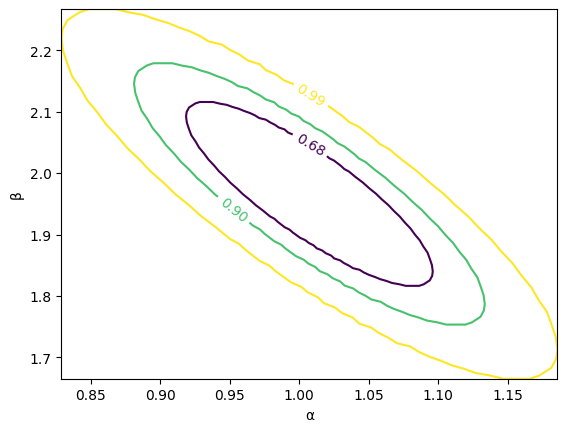

In [68]:
# draw three confidence regions with 68%, 90%, 99% confidence level
m.draw_mncontour("α", "β", cl=(0.68, 0.9, 0.99));

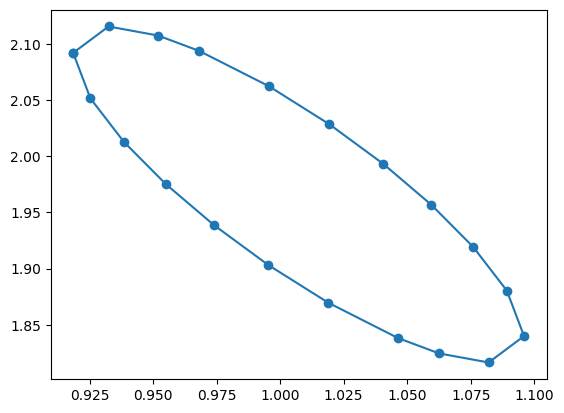

In [69]:
# get individual contours to plot them yourself
pts = m.mncontour("α", "β", cl=0.68, size=20)
x, y = np.transpose(pts)
plt.plot(x, y, "o-");

To make the contour look nicer, you can increase the `size` parameter or use the `interpolated` parameter to do cubic spline interpolation.

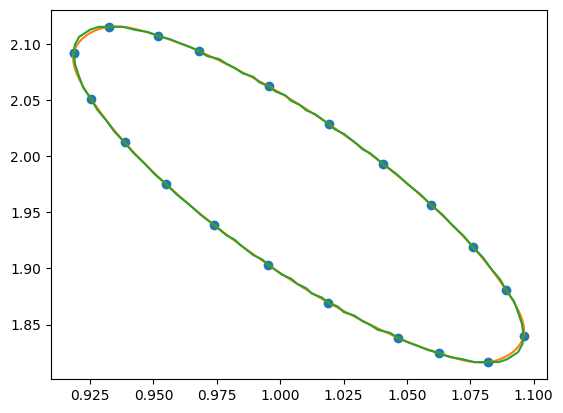

In [70]:
# draw original points
plt.plot(x, y, "o")

# draw interpolated points
pts2 = m.mncontour("α", "β", cl=0.68, size=20, interpolated=200)
x2, y2 = np.transpose(pts2)
plt.plot(x2, y2)

# actual curve at higher resolution
pts = m.mncontour("α", "β", cl=0.68, size=100)
x, y = np.transpose(pts)
plt.plot(x, y, "-");

To draw the 1D profile, call `Minuit.draw_mnprofile`.

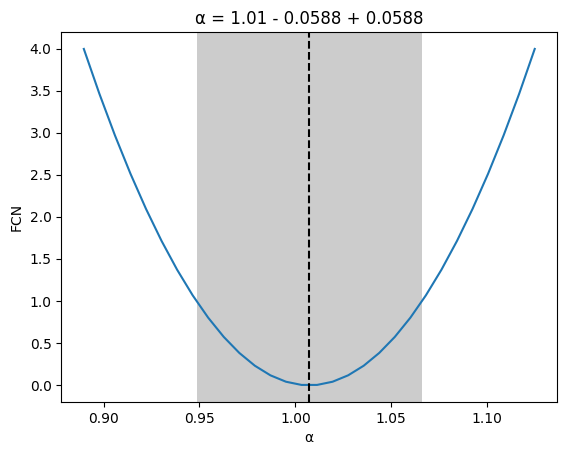

In [71]:
m.draw_mnprofile("α");

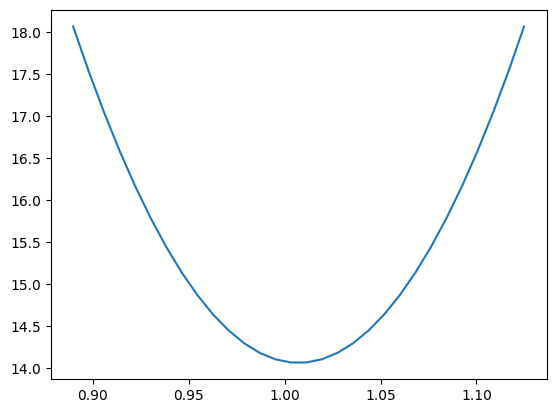

In [72]:
# or use this to plot the result of the scan yourself
a, fa, ok = m.mnprofile("α")
plt.plot(a, fa);

### Likelihood debugging

`mnmatrix`, `mnprofile`, and `mncontour` do Minos scans. If you have trouble with Minos or with the minimization, you should check how the likelihood looks like where you are. The following functions perform no minimization, they just draw the likelihood function as it is at certain coordinates.

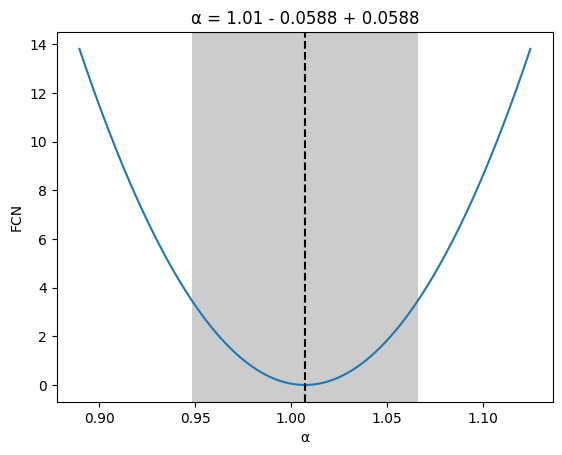

In [73]:
# draw 1D scan over likelihood, the minimum value is subtracted by default
m.draw_profile("α");

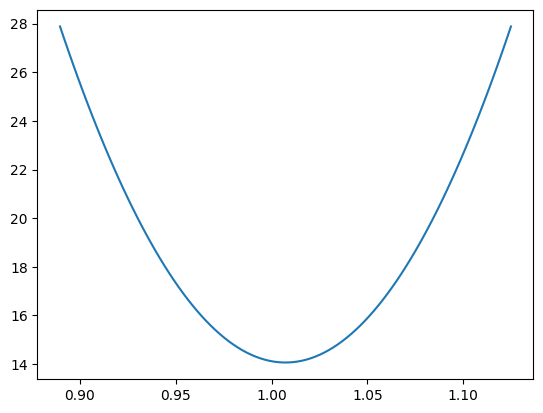

In [74]:
# or draw it yourself, the minimum value is not subtracted here
x, y = m.profile("α")
plt.plot(x, y);

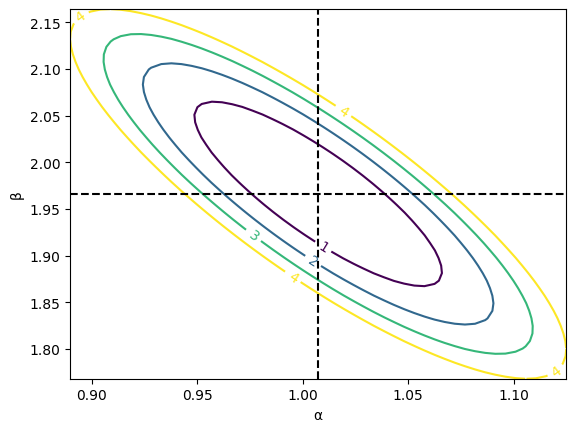

In [75]:
# draw 2D scan over likelihood
m.draw_contour("α", "β");

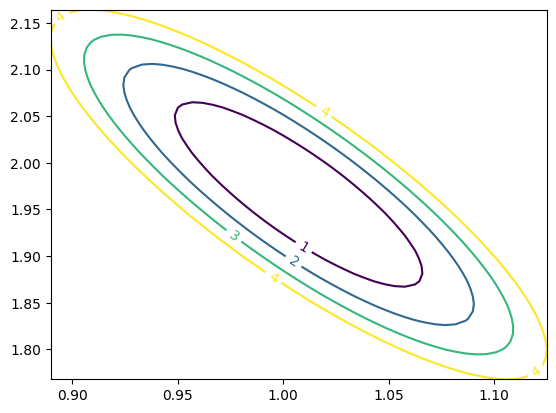

In [76]:
# or use this to plot the result of the scan yourself
x, y, z = m.contour("α", "β", subtract_min=True)
cs = plt.contour(x, y, z, (1, 2, 3, 4))  # these are not sigmas, just the contour values
plt.clabel(cs);

### Interactive fit

In Jupyter notebooks, it is possible to fit a model to data interactively, by calling `Minuit.interactive`. This functionality requires optional extra packages. If they are not there, you will get a friendly error message telling you what you need to install.

In [77]:
m.interactive()

You can change the parameter values with the sliders. Clicking the "Fit" button runs `Minuit.migrad` with these as starting values.

**Note:** If you see this notebook on ReadTheDocs or otherwise statically rendered, changing the sliders won't change the plot. This requires a running Jupyter kernel.

Interactive fits are useful to find starting values and to debug the fit. The following issues are easy to detect:

- Starting values are way off.
- You forgot to set limits on some parameters.
- Some parameters are strongly correlated.
- Your model is not analytical.

Strong correlations are caused when a change to one parameter can be almost perfectly undone by a changing one or more other parameters. If the model suddenly jumps when you move the sliders, this may indicate that the model is not analytical, but also note that the sliders have finite resolution and the model curve is also only drawn with finite resolution. Set tighter limits on the affected parameter or investigate the root cause with numerical experiments.

`Minuit.interactive` uses the `visualize` method on the cost function, if it is available. All built-in cost functions provide this method, but it only works for 1D distributions, since there is no obvious general way to visualize data-model agreement in higher dimensions. You can provide your visualization though, see the documentation of `Minuit.interactive`. This can also be useful to draw the model in more detail, for example, if you want to give different components in an additive model different colors (e.g. signal and background).